In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from functools import reduce

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

In [0]:
description = pd.read_csv("https://raw.githubusercontent.com/woldemarg/lightit_test/master/data/encoded/columns_description.csv", index_col=0)
description.reset_index(drop=True, inplace=True)

holidays = pd.read_csv("https://raw.githubusercontent.com/woldemarg/lightit_test/master/data/encoded/holidays_Japan.csv", parse_dates=[0])

# events = pd.read_csv("https://raw.githubusercontent.com/woldemarg/lightit_test/master/data/encoded/events_Hokkaido.csv")

# weather = pd.read_csv("https://raw.githubusercontent.com/woldemarg/lightit_test/master/data/encoded/weather_Hokkaido.csv")

In [0]:
jalan_dcols_to_parse = [5, 6, 7, 10]

jalan = pd.read_csv("https://raw.githubusercontent.com/woldemarg/lightit_test/master/data/encoded/jalan_shinchitose.csv",
                    parse_dates=jalan_dcols_to_parse)

rakuten_dcols_to_parse = [4, 6, 16, 19]

rakuten = pd.read_csv("https://raw.githubusercontent.com/woldemarg/lightit_test/master/data/encoded/rakuten_shinchitose.csv",
                      parse_dates=rakuten_dcols_to_parse)

In [0]:
jalan.columns = description.loc[48:93, "Row(EN)"]
rakuten.columns = description.loc[:47, "Row(EN)"]

cols_to_select = ["company_name",
                  "request_date_time",
                  "pickup_date_time",
                  "return_date_time",
                  "cancellation_date_time",
                  "is_cancelled"]

jalan = (jalan
         .assign(company_name="jalan")
         .assign(is_cancelled=np.invert(np.isnat(jalan.cancellation_date_time))
                 .astype(int))
         .loc[:, cols_to_select])

rakuten = (rakuten
           .assign(company_name="rakuten")
           .assign(is_cancelled=np.invert(
               np.isnat(rakuten.cancel_request_date_time)).astype(int))
           .rename(columns={
               "cancel_request_date_time": "cancellation_date_time"})
           .loc[:, cols_to_select])

In [0]:
def extract_date(row):
    """Get date from all date_time columns in a given row."""
    row.iloc[1:-1] = row.iloc[1:-1].dt.date
    return row


raw_data = (pd.concat([jalan, rakuten], axis=0)
            .reset_index(drop=True)
            .apply(extract_date, axis=1)
            .rename(columns=(lambda x: x[:-5]
                    if x.endswith("_time") else x)))

In [0]:
model_data = (raw_data.loc[raw_data.is_cancelled != 1, :]
              .groupby(["company_name", "pickup_date"])
              .agg(target=pd.NamedAgg(column="pickup_date",
                                      aggfunc="count"))
              #.pickup_date.agg("count").to_frame("target") #same as above
              .reset_index())

days_wo_rakuten = (model_data.groupby("pickup_date")
                   .filter(lambda g: all(g.company_name == "jalan"))
                   .assign(company_name="rakuten")
                   .assign(target=0))

days_wo_jalan = (model_data.groupby("pickup_date")
                 .filter(lambda g: all(g.company_name == "rakuten"))
                 .assign(company_name="jalan")
                 .assign(target=0))

seed = 1234

model_data_full = (pd.concat([model_data,
                              days_wo_rakuten,
                              days_wo_jalan], axis=0)
                   .sample(frac=1, axis=0, random_state=seed)
                   .reset_index(drop=True))

In [0]:
model_data = model_data_full[model_data_full.pickup_date < pd.Timestamp(2019, 1, 1)]

# model_data.to_csv("derived/model_data_py.csv", index=False)

In [0]:
timeline_raw = pd.pivot_table(model_data,
                              values="target",
                              index=["pickup_date"],
                              columns=["company_name"])

dates_index = pd.date_range(min(timeline_raw.index),
                            max(timeline_raw.index),
                            freq="D")

timeline_days = timeline_raw.reindex(dates_index, fill_value=0)

timeline_weeks = (timeline_days
                  .groupby(pd.PeriodIndex(timeline_days.index, freq="W"))
                  .sum())

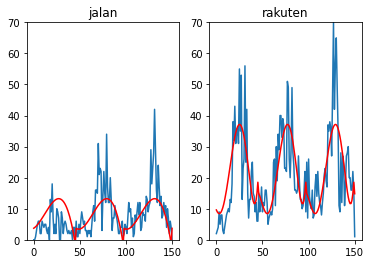

In [9]:
def apply_polynomial(comp, d):
    poly = np.poly1d(np.polyfit(range(1, 53),
                                comp.groupby(comp.index.week).mean(), d))
    rmse = np.sqrt(((poly(comp.index.week) - comp) ** 2).mean())
    return poly, rmse


def remove_seasonality(series):
    degree = 2
    poly, rmse = apply_polynomial(series, degree)

    while True:
        degree += 1
        new_poly, new_rmse = apply_polynomial(series, degree)
        if rmse - new_rmse < 0.5:
            best_poly, best_rmse = new_poly, new_rmse
            break
        rmse = new_rmse

    s_component = best_poly(series.index.week)
    a_series = np.subtract(series.reset_index(drop=True), s_component)

    return s_component, a_series

plt.figure()

for i, s in enumerate(["jalan", "rakuten"], 1):
    seasonality, adjusted = remove_seasonality(timeline_weeks[s])
    plt.subplot(1, 2, i)
    plt.plot(timeline_weeks[s].reset_index(drop=True))
    plt.plot(seasonality, color="red")
    plt.ylim(0, 70)
    plt.title(s)

plt.show()

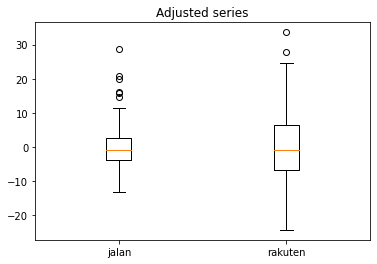

In [10]:
rakuten_seasonality, rakuten_adjusted = remove_seasonality(timeline_weeks.rakuten)
jalan_seasonality, jalan_adjusted = remove_seasonality(timeline_weeks.jalan)

plt.figure()
plt.boxplot([jalan_adjusted, rakuten_adjusted])
plt.xticks([1, 2],["jalan", "rakuten"])
plt.title("Adjusted series")
plt.show()

In [0]:
def get_outliers(*series):
    out = []
    for ser in series:
        zscores = list(np.abs(stats.zscore(ser)))
        indicies = [i for i, v in enumerate(zscores) if v >= 2.5]
        out.append(indicies)

    return list(dict.fromkeys(reduce(lambda x, y: x + y, out)))


out_periods = (timeline_weeks
               .reset_index()
               .iloc[get_outliers(jalan_adjusted,
                                  rakuten_adjusted)]["index"]
               .rename("period"))

format_to_year_week = lambda d: "_".join([str(d.year), str(d.week)])

out_weeks = out_periods.map(format_to_year_week)

In [12]:
format_to_year_week_2 = lambda d: "_".join([str(d.isocalendar()[0]),
                                            str(d.isocalendar()[1])])

model_data.loc[:, "year_week"] = (model_data.pickup_date
                                  .apply(format_to_year_week_2))

model_data = model_data.loc[~model_data.year_week.isin(out_weeks), :]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
def is_holidays_series(row):
    if (row.Japan_prev == 0 and
        row.Japan == 1 and
        row.Japan_next == 1):
        return 1
    if (row.wday == "Fri" and
          row.Japan == 1):
        return 1
    if (row.wday == "Sat" and
          row.Japan_next_next == 1):
        return 1

    return 0


holidays_mod = (holidays
                .assign(Japan_prev=holidays.Japan.shift(1))
                .assign(Japan_next=holidays.Japan.shift(-1))
                .assign(Japan_next_next=holidays.Japan.shift(-2))
                .assign(wday=holidays.day.apply(lambda d: d.strftime("%a"))))

holidays.loc[:, "is_holidays_series"] = holidays_mod.apply(is_holidays_series,
                                                    axis=1)
holidays.loc[:, "day"] = holidays.day.dt.date

model_data = (model_data
              .merge(holidays,
                     how="left",
                     left_on="pickup_date",
                     right_on="day")
              .drop(["day", "Japan", "year_week"], axis=1))

train = (model_data
         .assign(month=model_data.pickup_date.apply(lambda d: d.strftime("%b")))
         .assign(wday=model_data.pickup_date.apply(lambda d: d.strftime("%a")))
         .drop(["pickup_date"], axis=1))

Ridge: 1.992237 (0.137683)
Lasso: 2.384001 (0.189029)
KNN: 2.169647 (0.106505)
RF: 2.118130 (0.099179)
GBR: 2.023512 (0.135227)
SVR: 2.077625 (0.144465)


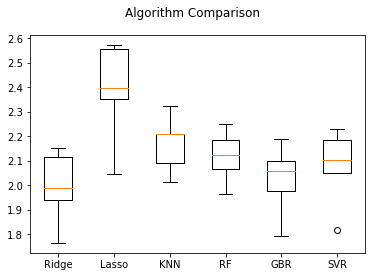

In [14]:
y = train.target
X = train.drop(["target"], axis=1)

categorical_cols = [cname for cname in X
                    if X[cname].dtype == "object"]

OH_encoder = OneHotEncoder(handle_unknown="error",
                           drop="first", sparse=False)

OH_cols = pd.DataFrame(OH_encoder
                       .fit_transform(X[categorical_cols]))

OH_cols_names = OH_encoder.get_feature_names(categorical_cols)
OH_cols.columns = OH_cols_names

num_X = X.drop(categorical_cols, axis=1)
OH_X = pd.concat([num_X, OH_cols], axis=1)


models = []
models.append(("Ridge", Ridge(random_state=seed)))
models.append(("Lasso", Lasso(random_state=seed)))
models.append(("KNN", KNeighborsRegressor()))
models.append(("RF", RandomForestRegressor(random_state=seed)))
models.append(("GBR", GradientBoostingRegressor(random_state=seed)))
models.append(("SVR", SVR()))


results = []
names = []

scoring = "neg_root_mean_squared_error"


for name, model in models:
    cv_results = -1 * cross_val_score(model,
                                      OH_X,
                                      y,
                                      scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

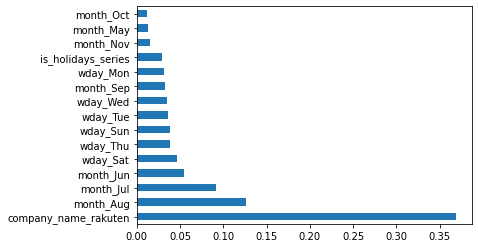

In [15]:
# create an object of the RandomForestRegressor
model_RF = RandomForestRegressor(random_state=seed)

# fit the model with the training data
rf_default = model_RF.fit(OH_X, y)


feat_importances = pd.Series(rf_default.feature_importances_,
                             index=OH_X.columns)


plt.figure()
feat_importances.nlargest(15).plot(kind="barh")
plt.show()

In [16]:
train_alt = (train
             .assign(is_weekend=(train.wday.isin(["Sat", "Sun"])) * 1)
             .drop(["wday"], axis=1))

X_alt = train_alt.drop(["target"], axis=1)

categorical_cols_alt = [cname for cname in X_alt
                        if X_alt[cname].dtype == "object"]

OH_cols_alt = pd.DataFrame(OH_encoder
                           .fit_transform(X_alt[categorical_cols_alt]))

OH_cols_names_alt = OH_encoder.get_feature_names(categorical_cols_alt)
OH_cols_alt.columns = OH_cols_names_alt

num_X_alt = X_alt.drop(categorical_cols_alt, axis=1)
OH_X_alt = pd.concat([num_X_alt, OH_cols_alt], axis=1)

scores_alt = -1 * cross_val_score(model_RF,
                                  OH_X_alt,
                                  y,
                                  scoring=scoring)

msg = "RF_alt: %f (%f)" % (scores_alt.mean(), scores_alt.std())
print(msg)

RF_alt: 2.008544 (0.136962)


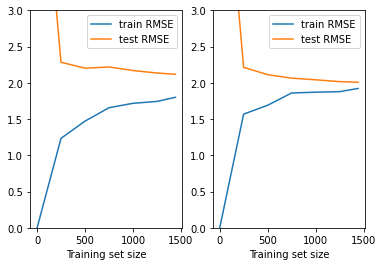

In [17]:
train_sizes = [1, 250, 500, 750, 1000, 1250, 1443]


def compare_learning_curves(predictors,
                            target,
                            train_sizes):
    train_sizes, train_scores, validation_scores = learning_curve(
        model_RF,
        predictors,
        target,
        train_sizes=train_sizes,
        cv=5,
        scoring="neg_root_mean_squared_error")

    train_scores_mean = -train_scores.mean(axis=1)
    validation_scores_mean = -validation_scores.mean(axis=1)

    plt.plot(train_sizes,
             train_scores_mean,
             label="train RMSE")
    plt.plot(train_sizes,
             validation_scores_mean,
             label="test RMSE")
    plt.legend()
    plt.xlabel("Training set size")
    plt.ylim(0, 3)


plt.figure()
for i, data in enumerate([OH_X, OH_X_alt], 1):
    plt.subplot(1, 2, i)
    compare_learning_curves(data, y, train_sizes)

In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

# Number of features to consider at every split
max_features = ["auto", "sqrt"]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {"n_estimators": n_estimators,
               "max_features": max_features,
               "max_depth": max_depth,
               "min_samples_split": min_samples_split,
               "min_samples_leaf": min_samples_leaf,
               "bootstrap": bootstrap}

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=model_RF,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=seed,
                               n_jobs=-1)
# Fit the random search model
rf_random.fit(OH_X_alt, y)

print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished


{'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}


In [19]:
# Create the parameter grid based on the results of random search
param_grid = {
    "bootstrap": [True],
    "max_depth": [70, 90, 110],
    "max_features": [4, 5],
    "min_samples_leaf": [3, 4, 5],
    "min_samples_split": [8, 10, 12],
    "n_estimators": [1000, 1600]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid,
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(OH_X_alt, y)

best_grid_rf = grid_search.best_estimator_

print(grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  9.0min finished


{'bootstrap': True, 'max_depth': 90, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 1600}


In [20]:
pipe_data = (model_data
             .drop(["target"], axis=1)
             .set_index("pickup_date"))


def assign_month(x_data):
    get_month = lambda i: i.strftime("%b")
    return x_data.assign(month=x_data.index.map(get_month))


def assign_weekend(x_data):
    get_wday_name = lambda i: i.strftime("%a")
    return x_data.assign(is_weekend=[1 if get_wday_name(i) in (["Sat", "Sun"])
                                else 0 for i in x_data.index])

date_parser = Pipeline(steps=[
    ("get_month", FunctionTransformer(assign_month)),
    ("get_weekend", FunctionTransformer(assign_weekend))
    ])


col_processor = ColumnTransformer(
    transformers=[
        ("one_hot",
         OneHotEncoder(handle_unknown="ignore"),
         ["company_name", "month"])
        ]
    )


# Bundle preprocessing and modeling code in a pipeline
model_pipeline = Pipeline(steps=[
    ("parse_date", date_parser),
    ("pre_process", col_processor),
    ("build_model", best_grid_rf)])


scores_best = -1 * cross_val_score(model_pipeline,
                                   pipe_data,
                                   y,
                                   scoring=scoring)
msg = "RF_best: %f (%f)" % (scores_best.mean(), scores_best.std())
print(msg)

RF_best: 1.982376 (0.141506)


In [21]:
test_data = model_data_full[(model_data_full.pickup_date >= pd.Timestamp(2019, 1,1)) &
                            (model_data_full.pickup_date < pd.Timestamp(2019, 3, 1))]

X_test = (test_data
          .merge(holidays,
                 how="left",
                 left_on="pickup_date",
                 right_on="day")
          .drop(["day", "Japan", "target"], axis=1)
          .set_index("pickup_date"))

y_test = test_data.target

model_pipeline.fit(pipe_data, y)

msg = "RMSE on test: %f" % (mean_squared_error(y_test,
                                               model_pipeline.predict(X_test))**0.5)
print(msg)


RMSE on test: 1.164313
